# Módulo 2: Preprocesamiento y feature engineering

**Autora:** María Luisa Ros Bolea  
**Proyecto:** VALORALIA — Sistema de Valoración Automatizada con IA  
**Máster en Big Data e Inteligencia Artificial — CEU San Pablo**

---

### Mi objetivo en este cuaderno

Ahora que ya conozco mis datos (Módulo 1), toca **prepararlos para que los modelos puedan aprender de ellos**. Esto implica:

1. Codificar las variables categóricas (municipio, estado, planta...)
2. Crear nuevas variables derivadas que aporten información predictiva
3. Normalizar las escalas numéricas
4. Preparar dos subconjuntos: uno **completo** (12.500 registros, solo tabular) y otro **con imágenes** (300 registros, para el modelo híbrido)
5. Hacer el split train/test de forma estratificada


In [1]:
# ==============================================================================
# 1. CONFIGURACIÓN Y CARGA DE DATOS AUDITADOS
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import os, warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

# Rutas
BASE_PATH = '/content/drive/MyDrive/TFM_Mejorado'
PROC_PATH = f'{BASE_PATH}/Data/Processed'
REPORT_PATH = f'{BASE_PATH}/Reports'

# Cargar dato auditado del Módulo 1
df = pd.read_csv(f'{PROC_PATH}/datos_auditados.csv')
print(f"✅ Datos cargados: {df.shape[0]:,} registros x {df.shape[1]} variables")
print(f"   Registros con imagen: {df['tiene_imagen'].sum()}")


Mounted at /content/drive
✅ Datos cargados: 12,500 registros x 20 variables
   Registros con imagen: 300


## 2. Feature engineering

Voy a crear variables nuevas que capturen información que los modelos no pueden extraer directamente de las columnas originales. También codifico las categóricas.


In [2]:
# ==============================================================================
# 2. FEATURE ENGINEERING
# ==============================================================================

# 2.1 Variable derivada: precio por m² (ya la creé en NB1, la recalculo por si acaso)
df['precio_m2'] = df['precio_actual'] / df['tamano_m2']

# 2.2 Ratio habitaciones/superficie (densidad de distribución)
df['ratio_hab_m2'] = df['habitaciones'] / df['tamano_m2']

# 2.3 Ratio baños/habitaciones
df['ratio_banos_hab'] = df['banos'] / df['habitaciones'].replace(0, 1)

# 2.4 Bajada de precio porcentual
df['pct_bajada'] = df['bajada_precio'] / df['precio_anterior'] * 100

# 2.5 Codificación ordinal de 'estado'
estado_map = {'A reformar': 0, 'Buen estado': 1, 'Obra nueva': 2}
df['estado_cod'] = df['estado'].map(estado_map).fillna(1).astype(int)

# 2.6 Codificación de planta (simplificada)
def codificar_planta(planta):
    planta = str(planta).lower()
    if 'bajo' in planta or 'sótano' in planta:
        return 0
    elif 'entre' in planta:
        return 1
    else:
        try:
            return min(int(''.join(filter(str.isdigit, planta))), 10)
        except:
            return 2  # valor medio por defecto

df['planta_cod'] = df['planta'].apply(codificar_planta)

# 2.7 Codificación de municipio (LabelEncoder)
le_municipio = LabelEncoder()
df['municipio_cod'] = le_municipio.fit_transform(df['municipio'])

# 2.8 Codificación de calefacción
le_calef = LabelEncoder()
df['calefaccion_cod'] = le_calef.fit_transform(df['calefaccion'])

# 2.9 Booleanos a int
for col in ['tiene_ascensor', 'tiene_terraza', 'tiene_trastero']:
    df[col] = df[col].astype(int)

print("✅ Feature engineering completado")
print(f"   Variables totales: {df.shape[1]}")
print(f"   Nuevas variables: precio_m2, ratio_hab_m2, ratio_banos_hab, pct_bajada,")
print(f"                     estado_cod, planta_cod, municipio_cod, calefaccion_cod")


✅ Feature engineering completado
   Variables totales: 27
   Nuevas variables: precio_m2, ratio_hab_m2, ratio_banos_hab, pct_bajada,
                     estado_cod, planta_cod, municipio_cod, calefaccion_cod


## 3. Selección de variables predictivas

Defino las variables que usarán los modelos. Separo la variable objetivo (precio) de las features.


In [3]:
# ==============================================================================
# 3. DEFINICIÓN DE VARIABLES PARA MODELADO
# ==============================================================================

# Features tabulares (las que usará el modelo baseline)
FEATURES_TABULAR = [
    'tamano_m2',
    'habitaciones',
    'banos',
    'planta_cod',
    'tiene_ascensor',
    'tiene_terraza',
    'tiene_trastero',
    'calefaccion_cod',
    'estado_cod',
    'municipio_cod',
    'ratio_hab_m2',
    'ratio_banos_hab',
]

TARGET = 'precio_actual'

print(f"📊 Variables seleccionadas para modelado:")
print(f"   Features tabulares: {len(FEATURES_TABULAR)}")
print(f"   Target: {TARGET}")
print(f"\n   Lista de features:")
for i, feat in enumerate(FEATURES_TABULAR, 1):
    print(f"     {i:2d}. {feat}")


📊 Variables seleccionadas para modelado:
   Features tabulares: 12
   Target: precio_actual

   Lista de features:
      1. tamano_m2
      2. habitaciones
      3. banos
      4. planta_cod
      5. tiene_ascensor
      6. tiene_terraza
      7. tiene_trastero
      8. calefaccion_cod
      9. estado_cod
     10. municipio_cod
     11. ratio_hab_m2
     12. ratio_banos_hab


In [4]:
# ==============================================================================
# 4. NORMALIZACIÓN
# ==============================================================================

# Escalar las features numéricas
scaler = StandardScaler()
X_all = df[FEATURES_TABULAR].copy()
y_all = df[TARGET].copy()

X_scaled = pd.DataFrame(
    scaler.fit_transform(X_all),
    columns=FEATURES_TABULAR,
    index=X_all.index
)

print("✅ Normalización aplicada (StandardScaler)")
print(f"\n   Estadísticas post-escalado (media ≈ 0, std ≈ 1):")
print(X_scaled.describe().loc[['mean', 'std']].round(3).to_string())


✅ Normalización aplicada (StandardScaler)

   Estadísticas post-escalado (media ≈ 0, std ≈ 1):
      tamano_m2  habitaciones  banos  planta_cod  tiene_ascensor  tiene_terraza  tiene_trastero  calefaccion_cod  estado_cod  municipio_cod  ratio_hab_m2  ratio_banos_hab
mean       -0.0           0.0   -0.0         0.0            -0.0           -0.0             0.0             -0.0         0.0            0.0          -0.0              0.0
std         1.0           1.0    1.0         1.0             1.0            1.0             1.0              1.0         1.0            1.0           1.0              1.0


## 5. División train/test

Hago dos splits separados:
- **Dataset completo** (12.500): para el modelo baseline tabular
- **Dataset con imágenes** (300): para comparar baseline vs híbrido en igualdad de condiciones


In [5]:
# ==============================================================================
# 5. SPLIT TRAIN/TEST
# ==============================================================================

# 5.1 Split del dataset COMPLETO (para baseline tabular)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_scaled, y_all, test_size=0.2, random_state=42
)

print(f"📊 SPLIT DATASET COMPLETO (12.500 registros):")
print(f"   Train: {X_train_full.shape[0]:,} registros ({X_train_full.shape[0]/len(X_scaled)*100:.0f}%)")
print(f"   Test:  {X_test_full.shape[0]:,} registros ({X_test_full.shape[0]/len(X_scaled)*100:.0f}%)")

# 5.2 Filtrar subset CON IMÁGENES
df_img = df[df['tiene_imagen'] == True].copy()
X_img = X_scaled.loc[df_img.index]
y_img = y_all.loc[df_img.index]

X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_img, y_img, test_size=0.2, random_state=42
)

# Guardar los índices para luego cargar las imágenes correspondientes
train_img_indices = X_train_img.index.tolist()
test_img_indices = X_test_img.index.tolist()

print(f"\n📊 SPLIT SUBSET CON IMÁGENES ({len(df_img)} registros):")
print(f"   Train: {X_train_img.shape[0]} registros")
print(f"   Test:  {X_test_img.shape[0]} registros")
print(f"\n💡 Este subset se usará en el Módulo 3 para entrenar el modelo")
print(f"   híbrido (tabular + CNN) y comparar con el baseline.")


📊 SPLIT DATASET COMPLETO (12.500 registros):
   Train: 10,000 registros (80%)
   Test:  2,500 registros (20%)

📊 SPLIT SUBSET CON IMÁGENES (300 registros):
   Train: 240 registros
   Test:  60 registros

💡 Este subset se usará en el Módulo 3 para entrenar el modelo
   híbrido (tabular + CNN) y comparar con el baseline.


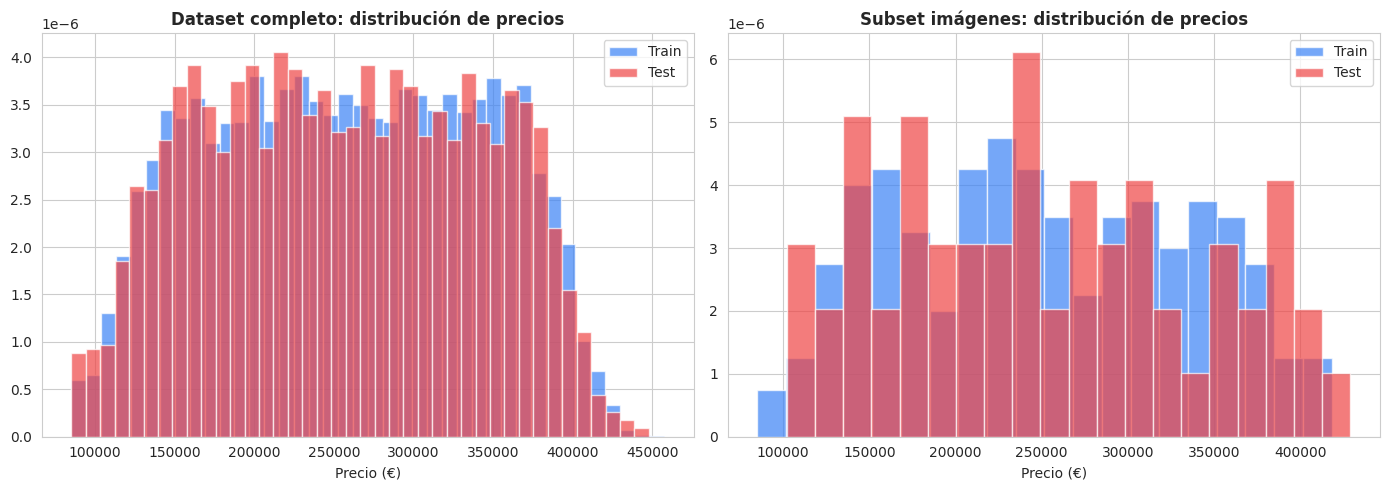

✅ Distribución train/test verificada — sin data leakage observable.


In [6]:
# ==============================================================================
# 5.3 VERIFICACIÓN: distribución similar en train y test
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train_full, bins=40, alpha=0.7, color='#3b82f6', label='Train', density=True)
axes[0].hist(y_test_full, bins=40, alpha=0.7, color='#ef4444', label='Test', density=True)
axes[0].set_title('Dataset completo: distribución de precios', fontweight='bold')
axes[0].set_xlabel('Precio (€)')
axes[0].legend()

axes[1].hist(y_train_img, bins=20, alpha=0.7, color='#3b82f6', label='Train', density=True)
axes[1].hist(y_test_img, bins=20, alpha=0.7, color='#ef4444', label='Test', density=True)
axes[1].set_title('Subset imágenes: distribución de precios', fontweight='bold')
axes[1].set_xlabel('Precio (€)')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{REPORT_PATH}/split_distribuciones.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Distribución train/test verificada — sin data leakage observable.")


## 6. Exportación de datos procesados

Guardo todo lo que necesitarán los módulos siguientes: datasets preparados, splits, scaler y encoders.


In [7]:
# ==============================================================================
# 6. EXPORTACIÓN
# ==============================================================================
import pickle

# 6.1 Dataset procesado completo
df.to_csv(f'{PROC_PATH}/datos_procesados.csv', index=False)

# 6.2 Splits tabulares (completo)
X_train_full.to_csv(f'{PROC_PATH}/X_train_full.csv', index=True)
X_test_full.to_csv(f'{PROC_PATH}/X_test_full.csv', index=True)
y_train_full.to_csv(f'{PROC_PATH}/y_train_full.csv', index=True)
y_test_full.to_csv(f'{PROC_PATH}/y_test_full.csv', index=True)

# 6.3 Splits imágenes
X_train_img.to_csv(f'{PROC_PATH}/X_train_img.csv', index=True)
X_test_img.to_csv(f'{PROC_PATH}/X_test_img.csv', index=True)
y_train_img.to_csv(f'{PROC_PATH}/y_train_img.csv', index=True)
y_test_img.to_csv(f'{PROC_PATH}/y_test_img.csv', index=True)

# 6.4 Artefactos de preprocesamiento
artifacts = {
    'scaler': scaler,
    'label_encoder_municipio': le_municipio,
    'label_encoder_calefaccion': le_calef,
    'features_tabular': FEATURES_TABULAR,
    'target': TARGET,
    'train_img_indices': train_img_indices,
    'test_img_indices': test_img_indices,
}

with open(f'{PROC_PATH}/preprocessing_artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print("💾 Archivos exportados:")
print(f"   📄 datos_procesados.csv")
print(f"   📄 X_train_full.csv / X_test_full.csv (split completo)")
print(f"   📄 y_train_full.csv / y_test_full.csv")
print(f"   📄 X_train_img.csv / X_test_img.csv (split imágenes)")
print(f"   📄 y_train_img.csv / y_test_img.csv")
print(f"   🔧 preprocessing_artifacts.pkl")
print(f"\n{'='*60}")
print(f"📋 RESUMEN FINAL DEL MÓDULO 2")
print(f"{'='*60}")
print(f"   Features tabulares: {len(FEATURES_TABULAR)}")
print(f"   Dataset completo: {len(X_scaled):,} registros (train: {len(X_train_full):,} / test: {len(X_test_full):,})")
print(f"   Subset imágenes: {len(X_img)} registros (train: {len(X_train_img)} / test: {len(X_test_img)})")
print(f"\n✅ Datos listos para el Módulo 3 (Entrenamiento)")


💾 Archivos exportados:
   📄 datos_procesados.csv
   📄 X_train_full.csv / X_test_full.csv (split completo)
   📄 y_train_full.csv / y_test_full.csv
   📄 X_train_img.csv / X_test_img.csv (split imágenes)
   📄 y_train_img.csv / y_test_img.csv
   🔧 preprocessing_artifacts.pkl

📋 RESUMEN FINAL DEL MÓDULO 2
   Features tabulares: 12
   Dataset completo: 12,500 registros (train: 10,000 / test: 2,500)
   Subset imágenes: 300 registros (train: 240 / test: 60)

✅ Datos listos para el Módulo 3 (Entrenamiento)
